<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [20]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import time

Загружаем датафрейм, распознаем даты и формируем новых индексы.

In [21]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Изучим общую информацию.

In [22]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [23]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверяем индексы на монотонность.

In [25]:
print(df.index.is_monotonic)

True


Ресемплируем по суммарному значению за час и построим график.

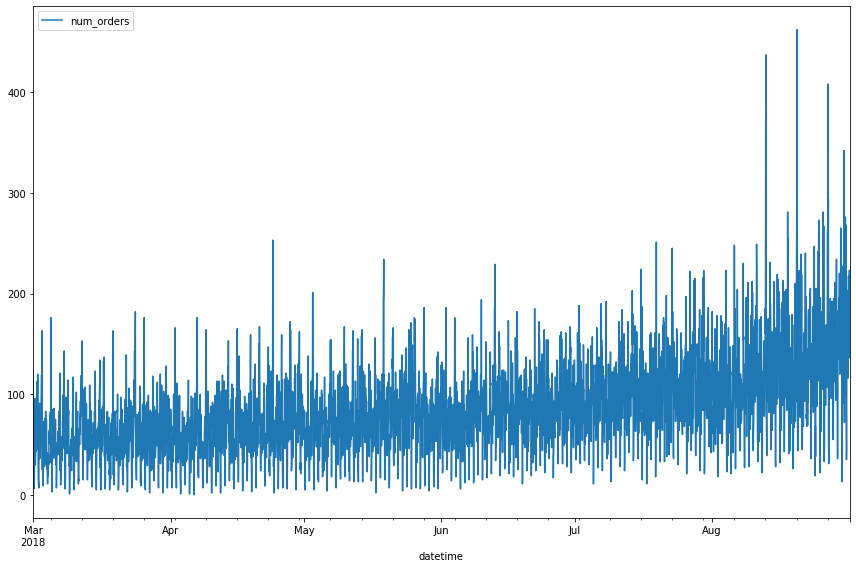

In [26]:
df = df.resample('1H').sum()
df.plot(figsize=(12,8))
plt.tight_layout()

Посмотрим на статистическую информацию после ресемплирования.

In [27]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


### Вывод
- Индексы монотонные, пропусков нет.
- Историчесие данные предоставлены за 6 месяцев с 2018-03 до 2018-08.
- Данные ресемплированы суммой по одному часу.
- Среднее число заказов в час за 6 месяцев составляет 84, при стандартном отклонении 45. 
- Имеются выборосы до 462 заказов в час, минимальоне число заказов 0.
- График числа заказов нелинейно растет.

## Анализ

Разложим временной ряд за предпоследний месяц (чтобы избежать подглядывания таргета) на тренд, сезонность и остаток. 

In [28]:
decomposed = seasonal_decompose(df['2018-07':'2018-07']) 

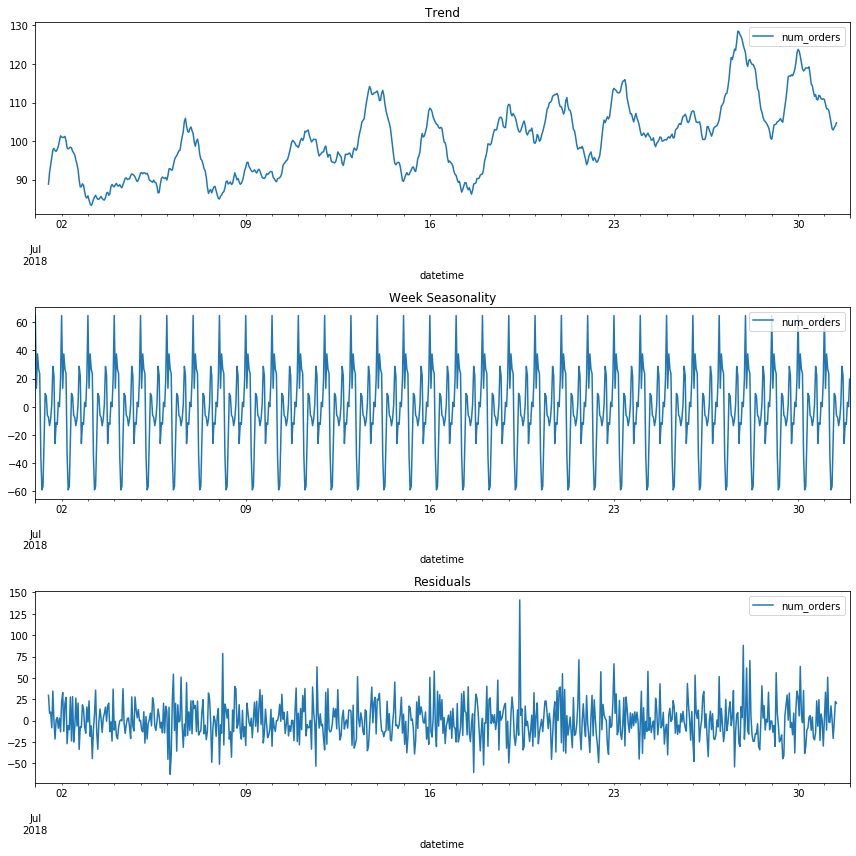

In [29]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())  
plt.title('Week Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())   
plt.title('Residuals')

plt.tight_layout()

In [30]:
decomposed.resid.describe()

,num_orders
count,720.000000
mean,0.213021
std,22.757243
min,-62.631424
25%,-13.776736
50%,-1.570312
75%,13.017361
max,141.153993


По графикам декомпозиции:
- Месячный тренд линейно с колебаниям возрастает.
- Распределение сезонной составляющей выглядит стационарным с периодом равным сутки.
- Составляющая шума имеет стандартное отклонение 22,8 и максимальное значение 141,15.

Построим график суточной сезонности.

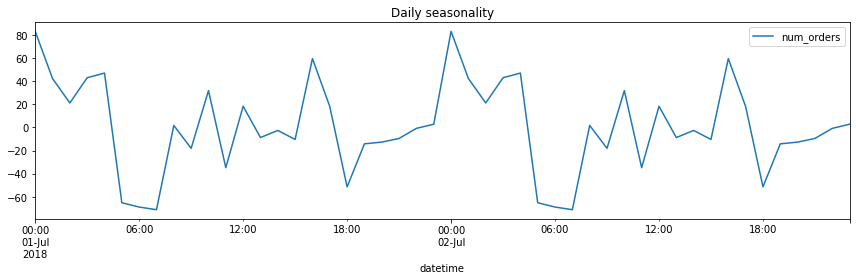

In [31]:
seasonal_decompose(df['2018-07-01':'2018-07-02']).seasonal.plot(ax=plt.gca(), figsize=(12, 4))
plt.title('Daily seasonality')
plt.tight_layout()

Минимум заказов приходится на 5-7 утра, максимум около полуночи. Так же имеется существенное снижение заказов в районе 18:00. Возможно в дальнейшем выделим часы наименьших заказов как отдельный признак.

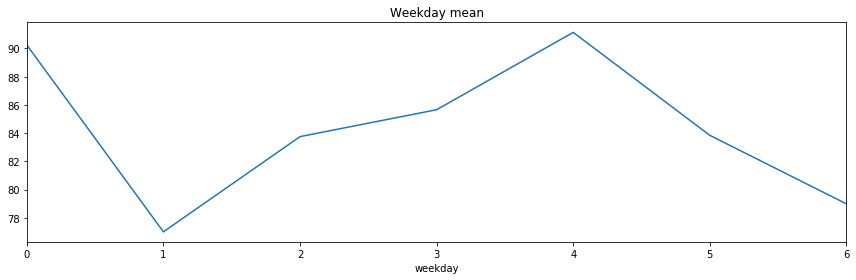

In [32]:
data = df.copy()
data["weekday"] = data.index.weekday
data.groupby('weekday')['num_orders'].mean().plot(figsize=(12, 4))
plt.title('Weekday mean')
plt.tight_layout()

Меньше всего в среднем заказов во вторник и воскресенье. Максимум в пятницу и понедельник. Попробуем добавить дополнительный признак, если день недели вторник и воскресенье. Предположим что таким образом можно точнее прогнозировать изменение заказов в течение недели.

Построим график тренда за 5 месяцев наблюдений.

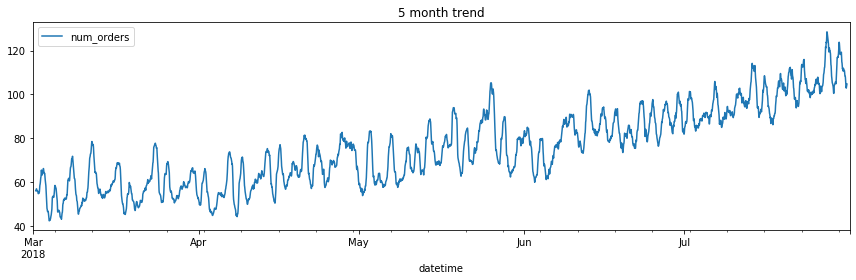

In [33]:
seasonal_decompose(df['2018-03':'2018-07']) .trend.plot(ax=plt.gca(), figsize=(12, 4))
plt.title('5 month trend')
plt.tight_layout()

Имеется тендеция к небольшому нелинейному росту, который для построения модели будем считать линейным.

### Вывод
Из анализа графиков для построения модели:
- создадим признак месяца для учета ежемесячного роста заказов.
- создадим признак дня недели для учета неравномерности средних заказов в течение недели.
- создадим новый признак признак для двух дней недели - вторника и восресенья, так как в эти дни в среднем наблюдается существенное снижение количества заказов. 
- создадим признак часа.
- создадим признак часов спада заказов - в 5, 6, 7, 18 часов. 
- зависимости спроса от числа месяца не обнаружено, поэтому в модели не будем его испльзовать.

## Обучение

Функция для получения признаков по пункту 2.1, смещения таргета, скользящего среднего и разделения выборки на обучающую и тестовую.

In [34]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['tue_and_sun'] = data.dayofweek.isin([1,6])*1
    data["hour"] = data.index.hour
    data["rush_hour"] = data.index.hour.isin([5,6,7,18])*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() 
    
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    X_train = train.drop('num_orders', axis = 1)
    y_train = train['num_orders']
    X_test = test.drop('num_orders', axis = 1)
    y_test = test['num_orders']
    
    return X_train, y_train, X_test, y_test

Функция для тестирования моделей с возвратом времени обучения, времени предикта и RMSE.

In [35]:
def time_score(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    predict = model.predict(X_test)
    predict_time = time.time() - start

    return train_time, predict_time, mean_squared_error(y_test, predict)**0.5

### Линейная регрессия

Подбирить оптимальное признаки будем по валидационной выборке, поэтому вначале поделим выборку на обучающую и тестовую (в соотношении 9:1). И для получения признаков линейной регрессии будем отдавать функции make_features только тренировочную выборку.

In [36]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train.shape, test.shape

((3974, 1), (442, 1))

Для линейной регрессии на обучающей выборке подберем параметры величины смещения таргета и окна скользящего среднего для поиска модели с наименьшим RMSE. 

In [37]:
best_lag_lr = 0
best_roll_size_lr = 0
best_rmse_lr = 48
for lag in tqdm(range(6, 337, 6)):
    for roll_size in range(2, 5, 1):

        X_train_lr, y_train_lr, X_valid_lr, y_validt_lr = make_features(train, lag, roll_size)
        

        lr = LinearRegression()
        lr.fit(X_train_lr, y_train_lr)

        preds_test = lr.predict(X_valid_lr)
        rmse = mean_squared_error(y_validt_lr, preds_test) ** 0.5
        if rmse < best_rmse_lr :
            best_rmse_lr = rmse
            best_lag_lr = lag
            best_roll_size_lr = roll_size
            

100%|██████████| 56/56 [02:07<00:00,  2.28s/it]


In [38]:
print(f"RMSE на валидационной выборке: {best_rmse_lr}, максимальное смещение {best_lag_lr}, размер скользящей средней {best_roll_size_lr}")

RMSE на валидационной выборке: 28.174789819135395, максимальное смещение 336, размер скользящей средней 3


Для тестирования выделим фичи для линеной регрессии с наиблучшими параметрами смещения и скользящей средней. Так же разделим обучающую и тестовую выборку, выделим признаки и таргеты.

In [39]:
X_train_lr, y_train_lr, X_test_lr, y_test_lr = make_features(df, best_lag_lr, best_roll_size_lr)
X_train_lr.shape, y_train_lr.shape, X_test_lr.shape, y_test_lr.shape

((3638, 342), (3638,), (442, 342), (442,))

### RandomForest

Для моделей случайного леса и CatBoost примем максимальное смещение равное 48 (двое суток) и скользящее среднее за 2 часа. Пролучим фичи для поиска гиперпараметров моделей. 

In [40]:
X_train, y_train, X_test, y_test = make_features(df, 48, 2)

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3926, 54), (3926,), (442, 54), (442,))

Используем GridSearchCV с гиперпараметрами числа деревьем от 100 до 600 и кросс-валидацией по 3 фолдам временного ряда.

In [42]:
rf = RandomForestRegressor(random_state=12345)
cv = TimeSeriesSplit(n_splits=3)
params = {
    'n_estimators': [100, 200, 300, 400, 600],
}

grid_rf = GridSearchCV(rf, params, cv=cv, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

In [43]:
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. n_estimators=100, score=-535.090, total=   2.5s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................. n_estimators=100, score=-542.997, total=   5.3s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.8s remaining:    0.0s


[CV] ................. n_estimators=100, score=-912.151, total=   8.3s
[CV] n_estimators=200 ................................................
[CV] ................. n_estimators=200, score=-542.628, total=   5.4s
[CV] n_estimators=200 ................................................
[CV] ................. n_estimators=200, score=-535.069, total=  10.9s
[CV] n_estimators=200 ................................................
[CV] ................. n_estimators=200, score=-910.124, total=  16.7s
[CV] n_estimators=300 ................................................
[CV] ................. n_estimators=300, score=-540.338, total=   7.6s
[CV] n_estimators=300 ................................................
[CV] ................. n_estimators=300, score=-533.094, total=  16.2s
[CV] n_estimators=300 ................................................
[CV] ................. n_estimators=300, score=-911.359, total=  25.2s
[CV] n_estimators=400 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_st

Выведем оптимальные гиперпараметры.

In [44]:
grid_rf.best_params_

{'n_estimators': 300}

Выведем лучший скор на кросс-валидации.

In [45]:
np.abs(grid_rf.best_score_)**0.5

25.721525425371382

### CatBoostRegressor

Подберем гиперпараметр learning_rate при 100 итерациях и кросс-валидации по трем фолдам.

In [46]:
cbr = CatBoostRegressor(random_state=12345, iterations=100)
cv = TimeSeriesSplit(n_splits=3)

cbr = CatBoostRegressor(random_seed=12345, silent=True, cat_features=['month', 'dayofweek', 'tue_and_sun', 'rush_hour', 'hour'])

params = {
        'learning_rate': np.linspace(0.02, 0.15, 10)
}

grid_cbr = GridSearchCV(cbr, params, cv=cv, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)

In [47]:
grid_cbr.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... learning_rate=0.02, score=-541.005, total=  36.0s
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   36.0s remaining:    0.0s


[CV] ............... learning_rate=0.02, score=-507.944, total=  45.2s
[CV] learning_rate=0.02 ..............................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] ............... learning_rate=0.02, score=-860.426, total=  53.0s
[CV] learning_rate=0.034444444444444444 ..............................
[CV]  learning_rate=0.034444444444444444, score=-526.201, total=  35.2s
[CV] learning_rate=0.034444444444444444 ..............................
[CV]  learning_rate=0.034444444444444444, score=-496.553, total=  45.6s
[CV] learning_rate=0.034444444444444444 ..............................
[CV]  learning_rate=0.034444444444444444, score=-834.928, total=  53.0s
[CV] learning_rate=0.04888888888888889 ...............................
[CV]  learning_rate=0.04888888888888889, score=-528.906, total=  34.9s
[CV] learning_rate=0.04888888888888889 ...............................
[CV]  learning_rate=0.04888888888888889, score=-501.007, total=  46.2s
[CV] learning_rate=0.04888888888888889 ...............................
[CV]  learning_rate=0.04888888888888889, score=-876.275, total=  54.1s
[CV] learning_rate=0.06333333333333334 ...............................
[CV

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 22.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f94b3126b50>,
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': array([0.02      , 0.03444444, 0.04888889, 0.06333333, 0.07777778,
       0.09222222, 0.10666667, 0.12111111, 0.13555556, 0.15      ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

Выведем лучшие гиперпараметры при кросс-валидации.

In [48]:
grid_cbr.best_params_

{'learning_rate': 0.034444444444444444}

Выведем лучший скор на кросс-валидации.

In [49]:
np.abs(grid_cbr.best_score_)**0.5

24.88427050382923

### Вывод
- для моделей CatBoostRegressor и RandomForest подобраны гиперпараметры при кросс-валидации по двум фолдам временноо ряда.
- для модели линейной регрессии подобраны значения смещения таргета и окна скользящего среднего.
- Лучший RMSE=24,9 на валилидации показала модель CatBoostRegression.  
Другие модели показали похожие результаты: RandomFores RMSE=25,7, линейная регрессия RMSE=28,2.

## Тестирование

Для тестирования выделим фичи для линеной регрессии с наиблучшими параметрами смещения и скользящей средней. Так же разделим обучающую и тестовую выборку, выделим признаки и таргеты.

In [50]:
X_train_lr, y_train_lr, X_test_lr, y_test_lr = make_features(df, best_lag_lr, best_roll_size_lr)

In [51]:
X_train_lr.shape, y_train_lr.shape, X_test_lr.shape, y_test_lr.shape

((3638, 342), (3638,), (442, 342), (442,))

Аналогично, но с принятыми параметрами смещения и скользящего среднего для остальных моделей.

In [52]:
X_train, y_train, X_test, y_test = make_features(df, 48, 2)

In [53]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3926, 54), (3926,), (442, 54), (442,))

Создадим список для результатов тестирования и получим метрики моделей для тестовых выборок. Для модели линейной регрессии параметрами для настройки было значение сдвига и скользящего среднего, для других моделей гиперпараметры моделей. 

In [54]:
result = []

Проведем тестирование моделей и добавим результы в список.

In [55]:
result.append(time_score(lr, X_train_lr, y_train_lr, X_test_lr, y_test_lr))
result.append(time_score(grid_rf.best_estimator_, X_train, y_train, X_test, y_test))
result.append(time_score(grid_cbr.best_estimator_, X_train, y_train, X_test, y_test))

Сведем результаты в датафрейм.

In [56]:
analitic = pd.DataFrame(data=result,
             index=['LinearRegression', 'RandomForest', 'CatBoost'],
             columns=['trainig_time', 'predic_time', 'RMSE'])

In [57]:
analitic

,trainig_time,predic_time,RMSE
LinearRegression,0.829641,0.098955,34.299890
RandomForest,34.176463,0.055443,40.699677
CatBoost,60.113114,0.007894,39.309441


Построим график предсказанния и таргета лучшей модели на тесте -линейной регрессии. 

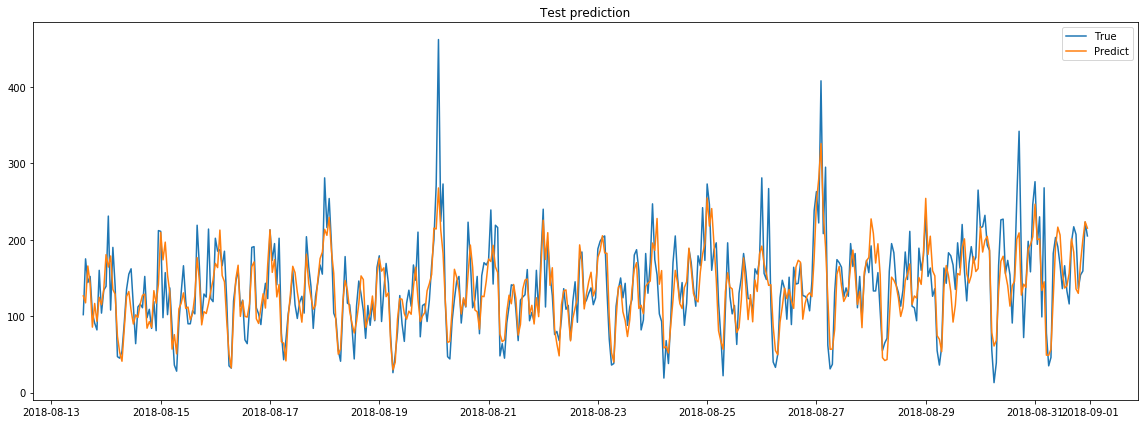

In [58]:
lr.fit(X_train_lr, y_train_lr)
preds_test = lr.predict(X_test_lr)

plt.figure(figsize=(16, 6))

plt.plot(y_test_lr, label='True')
plt.plot(y_test_lr.index, preds_test, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.tight_layout()

### Вывод 
При тестировании моделей лучшая метрика RMSE составила 34,3 у модели линейной регрессии.  
Все модели показали результаты хуже чем на валидационных данных. Возможная причина этого наличие аномально высоких значений таргета в тестовой выборке.  
Все модели имеют метрику RMSE выше 48.  
Результаты тестирования сведены в таблицу analitic, для лучшей модели построен график предиктов и таргета.

## Вывод
В исходном временном ряду за 6 месяцев с 2018-03 до 2018-08 индексы монотонные, пропусков нет.  
Данные ресемплированы суммой по одному часу.  
Среднее число заказов в час за 6 месяцев составляет 84, при стандартном отклонении 45.  
Имеются выборосы до 462 заказов в час, минимальоне число заказов 0.   

Для построения модели созданы признаки:
- Месяц, дня недели, дни недели среднего спада заказов (вторник и восресенье), час, часы спада заказов (5, 6, 7, 18 часов).
- Cмещение таргета и скользящее среднее.  

Рассмотрены модели линейной регрессии, RandomForestRegression и CatBoostRegression. 
- Проведен поиск оптимального смещение таргета и скользящего среднего на валидационных данных для линейной регрессии.
- Кросс-валидацией по трем фолдам подобраны гиперпараметры для моделей RandomForestRegression (число деревьев от 100 до 600) и CatBoostRegression (изменение learnig_rate от 0.02 до 0.15 на 100 итерациях). Параметры признаков не подбирались и приняты 48 - смещение зачения таргета, 2 - окно скользящего среднего.
- Лучший RMSE=24.9 на валидации показала модель CatBoostRegression с гиперпараметром learnig_rate=0.03444.
- На тестовых данных лучший RMSE=34,3 имеет модель линейной регрессии с максимальным смещением таргета на 336 часов (14 дней) и скользящим средним за 3 часа.
- Причиной снижения метрики на тестовых данных может быть наличие выбросов высоких значений заказов в период тестовой выборки.  

В целом все рассмотренные модели показывают значение метрики RMSE меньше стандартного отклонения числа заказов в час (45) и выше целевого RMSE 48. 
